In [1]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_likelihood, log_prior_global_uniform, log_probability

In [2]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("../results/values/brightnesstot_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)
flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("../results/values/brightness_TRAPPIST-1.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [47]:
#
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappistflux_M2[0]
brightness_flares, brightnesserror_flares = np.reshape(np.concatenate((flare1[0],flare2[0])), (2,4)), \
                                            np.reshape(np.concatenate((flare1[1], flare2[1])), (2,4))

iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [48]:
from scipy.optimize import minimize

parameters_op = []
t_star = 2648 #[K]
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial value for emcee 
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([5000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not to high
    if T_op > 25000 or T_op < 3000:
        T_op = 6000 
        
    #ensure fraction of area is not negative
    if a_op < 0:
        a_op = 0.3 
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [49]:
parameters_op



array([[9.21883563e+03, 3.00000000e-01],
       [4.96540231e+03, 3.00000000e-01]])

In [50]:
import emcee
import corner
import matplotlib.pyplot as plt

#better for every flare one fitting pipeline or let it stay like this?

samples_total, samplesflat_total = [],[] 

for i in range(len(brightness_flares)):
    
    
    pos = parameters_op[0] + 1e-3 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape
    
    print("Flare #" + str(i+1));
    
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_prior_global_uniform))
    sampler.run_mcmc(pos, 10000, progress=True);
    
    samplesflat_total.append(sampler.get_chain(discard=1000, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  0%|          | 9/10000 [00:00<01:54, 86.99it/s]

Flare #1


  0%|          | 10/10000 [00:00<01:43, 96.71it/s]

Flare #2


100%|██████████| 10000/10000 [01:22<00:00, 121.29it/s]


In [69]:
def plot_walker_emcee(samples):
    
    #Analysis Plot Walker
   
    labels = ["T", "a"]
    for j in range(len(samples)):
        fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
        for i in range(len(labels)):
            
            ax = axes[i]
            ax.plot(samples_total[j][:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples_total[j]))
            #ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
            axes[-1].set_xlabel("step number");
    return 


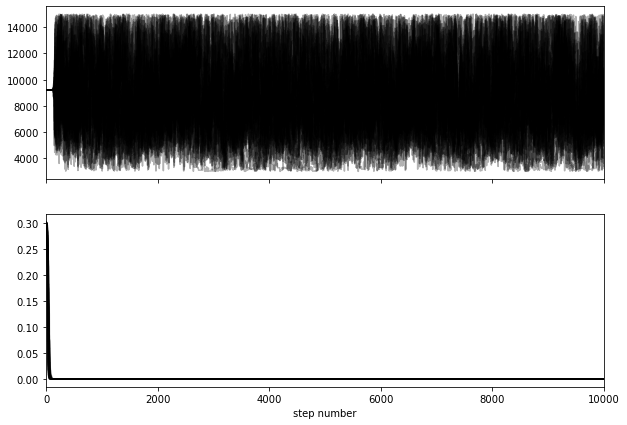

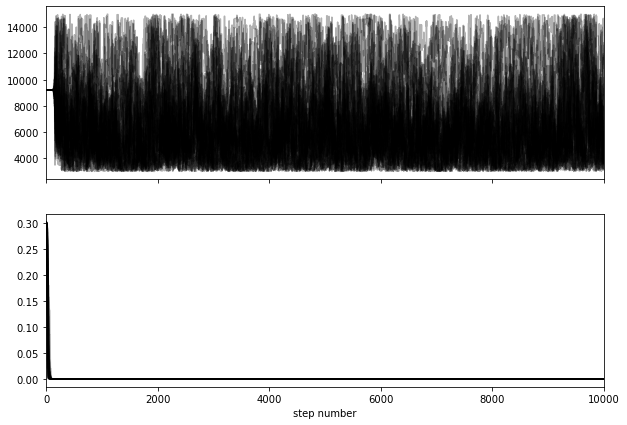

In [70]:
%matplotlib inline
plot_walker_emcee(samples_total)

In [87]:
def plot_corner_emcee(samples_flat):
    labels = ["T","a"]
    for j in range(len(samples_flat)):
        fig = corner.corner(
        samplesflat_total[j], labels=labels
        );
    return 



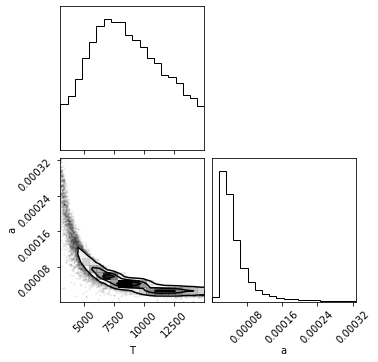

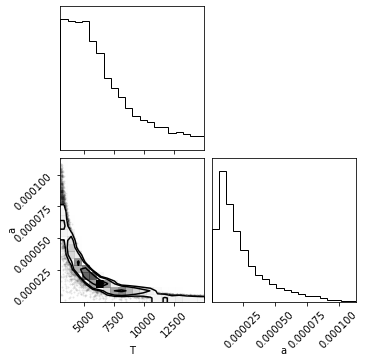

In [88]:
plot_corner_emcee(samplesflat_total)

In [82]:
results = display_median_from_chain(samplesflat_total)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:
from IPython.display import display, Math

def display_median_from_chain(samplesflat):
    
    T, Terror, a, aerror = [], [], [], []
    
    for j in range(len(samplesflat)):
        for i in range(2):
            mcmc = np.percentile(samplesflat[j][:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
            if i == 0:
                T_med = mcmc[1]
                T.append(T_med)
                Terror.append(q)
            if i == 1:
                a_med = mcmc[1]
                a.append(a_med) 
                aerror.append(q) 
                
    return T, Terror, a, aerror  

In [15]:
response = [np.nansum(response_M2[i]) for i in range(len(response_M2))]

<IPython.core.display.Javascript object>


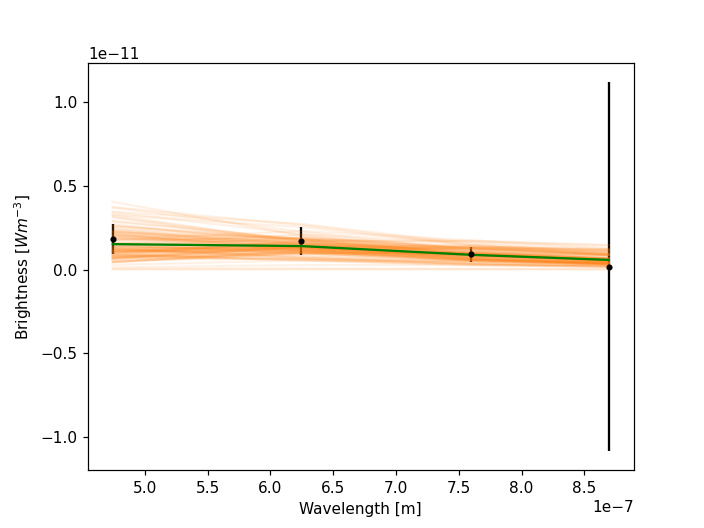

Text(0, 0.5, 'Brightness [$W m^{-3}$]')

In [60]:
%matplotlib notebook
#def plot_residual_plot(): 
inds = np.random.randint(len(samplesflat_total[0]), size=100) #
for ind in inds:
    sample = samplesflat_total[1][ind]
    plt.plot(wavelength_M2, _brightness_mod(wavelength_SED,limit,sample[0],sample[1], flux_SED,t_star, R_star = r_star, dist_star = dist_TRAP), "C1", alpha=0.1)
plt.plot(wavelength_M2, _brightness_mod(wavelength_SED,limit,T_med,a_med, flux_SED,t_star, R_star = r_star, dist_star = dist_star), "green", alpha=1)
plt.errorbar(wavelength_M2, brightness_flares[1], yerr=brightnesserror_flares[1], fmt=".k", capsize=0)
#plt.errorbar(wavelength_M2, brightness_flares[0]/response/5, yerr=brightnesserror_flares[0]/response/5, fmt=".k", capsize=0)
#plt.plot(wavelength_SED, brightness_mod_continous(wavelength_SED,T_med, a_med, flux_SED, t_star, R_star = r_star, dist_star = dist_star))
plt.xlabel("Wavelength [m]")
plt.ylabel(r"Brightness [$W m^{-3}$]")
#plt.legend() 

In [24]:
brightness_flares

array([[5.74516147e-11, 4.22547075e-11, 2.17100543e-11, 8.67612419e-12],
       [1.81192030e-12, 1.69265145e-12, 9.04967349e-13, 1.77293049e-13]])

In [ ]:
# Notes: 

'''
Open question, if I do that do I not do it twice?? This is a really good question. Because in the photometry, 
the information about the CCD effeciency should be in there already. Correct? Nope see enrics mail.

Next step: 
Functions of the analysis plots; stil bug with factor? I do not see where it is coming
from. 

'''